<a href="https://colab.research.google.com/github/chrober24/SL1_2021/blob/main/stylegan2_variations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## stylegan2

this notebook contains scripts for training a stylegan2 model as well as various scripts for generating images from a trained network and projecting into the network

Training requires connecting colab to google drive as the training process generates a large amount of data that cannot be hosted locally on colab.

Some of the generation scripts can be run without mounting to drive and require only that you load in a pretrained model pkl file

# setup

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b080d54b-c344-b7b3-25f8-aac9f701e474)


In [ ]:
#always use tensorflow1

%tensorflow_version 1.x


TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initial Setup

Only run this cell if you are using google drive to store your model

Run this cell if you’ve never run this repo in your Drive account. SKIP it if you have.

In [ ]:
#SKIP this if you already have a stylegan2 folder in your google drive
%cd /content/drive/MyDrive/
!mkdir stylegan2-aug-colab
%cd stylegan2-aug-colab/
!git clone -b augs-attn https://github.com/dvschultz/stylegan2
%cd stylegan2
!mkdir pkl
%cd pkl
!gdown --id 1JLqXE5bGZnlu2BkbLPD5_ZxoO3Nz-AvF #inception: https://drive.google.com/open?id=1JLqXE5bGZnlu2BkbLPD5_ZxoO3Nz-AvF
%cd ../
!mkdir results
!mkdir results/00001-pretrained
%cd results/00001-pretrained
!gdown --id 1UlDmJVLLnBD9SnLSMXeiZRO6g-OMQCA_
%cd ../../
%mkdir datasets

Run this cell if you are not storing files in google drive

This cell will install all necessary libraries to the Colab storage


In [ ]:
%tensorflow_version 1.x

# Derrick's repo (even if you trained with skyflynil this will work!)
!git clone https://github.com/dvschultz/stylegan2 #use this fork to get interpolation functions
!pip install opensimplex # needed for noise interpolation
%cd stylegan2

Cloning into 'stylegan2'...
remote: Enumerating objects: 552, done.
remote: Total 552 (delta 0), reused 0 (delta 0), pack-reused 552
Receiving objects: 100% (552/552), 22.47 MiB | 30.93 MiB/s, done.
Resolving deltas: 100% (285/285), done.
/content/stylegan2


## Return Setup
Run this cell if you’re picking up from a previous training.

In [ ]:
%cd /content/drive/MyDrive/stylegan2-aug-colab/stylegan2
#!git pull

/content/drive/MyDrive/stylegan2-aug-colab/stylegan2


dataset prep:
creates tfrecord 


In [ ]:
!python dataset_tool.py create_from_images_raw /content/drive/MyDrive/stylegan2-aug-colab/stylegan2/datasets/factory1 /content/drive/MyDrive/stylegan2-aug-colab/stylegan2/raw_images/factory1/

Loading images from "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/raw_images/factory1/"
detected 1149 images ...
Shuffle the images...
Creating dataset "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/datasets/factory1"
Adding the images to tfrecords ...
added images 0
added images 1000
Added 1149 images.


## Training

In the next cell set your pkl and `resume_kimg` counter. If this is your first time the settings below should work for you.

Use the next cell for transfer learning or restarting training

In [ ]:
pkl = "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00072-stylegan2-factory1-1gpu-config-f/network-snapshot-010132.pkl"
resume_kimg = 10132

the `AUG_PROB` environment setting tells the training loop how often to modify the real and fake images with augmentations. The default is `0.1` If you have a small training set you may want to go higher than that but note that the Karras paper does say if you set this value too high you may find it bleeds into the outputs.

Replace --dataset with your dataset name

In [ ]:
!AUG_PROB=0.2 python run_training.py --num-gpus=1 --mirror-augment=True --data-dir=./datasets --dataset=factory1 --config=config-f --resume-pkl=$pkl --resume-kimg=$resume_kimg --augmentations=True --metrics=None

Local submit - run_dir: results/00073-stylegan2-factory1-1gpu-config-f
dnnlib: Running training.training_loop.training_loop() on localhost...
Streaming data using training.dataset.TFRecordDataset...
Dataset shape = [3, 512, 512]
Dynamic range = [0, 255]
Label size    = 0
Loading networks from "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00072-stylegan2-factory1-1gpu-config-f/network-snapshot-010132.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.

G                             Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 0)              -               
lod                           -         ()                  -               
dlatent_avg            

# using the model

In [ ]:
%cd /content/drive/MyDrive/stylegan2-aug-colab/stylegan2
#!git pull

/content/drive/MyDrive/stylegan2-aug-colab/stylegan2


## generation

### RandomImage Generation and Interpolation

In [ ]:
%cd /content/drive/My\ Drive/stylegan2-aug-colab/stylegan2

/content/drive/My Drive/stylegan2-aug-colab/stylegan2


This code will create a sequence of png's smoothly blending between random points in the network.   

1.   Change line 41 to your network
2.   Change Tokyo to your image name on line 83
3.   lines 46-50 control settings like frame count/framerate
4.   smoothing_sec controls the blending between seeds. larger values will produce a slower blend. A value of 0 will produce unique images on every frame



In [ ]:
pkl = "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00029-stylegan2-sb-1gpu-config-f/network-snapshot-010505.pkl"

In [ ]:
# Copyright (c) 2019, NVIDIA Corporation. All rights reserved.
#
# This work is made available under the Nvidia Source Code License-NC.
# To view a copy of this license, visit
# https://nvlabs.github.io/stylegan2/license.html

import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib


import pretrained_networks

#----------------------------------------------------------------------------
def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y: y + img_h, x: x + img_w] = images[idx]
    return grid

def genGrid():

    tflib.init_tf()

    # Load pre-trained network.

    ## NOTE: insert model here:
    _G, _D, Gs = pretrained_networks.load_networks(pkl)


    grid_size = [1,1]

    image_zoom = 1
    duration_sec = 2
    smoothing_sec = 0
    mp4_fps = 24
    random_seed =150
    minibatch_size = 8
    cnt = 0
    num_frames = int(np.rint(duration_sec * mp4_fps))
    random_state = np.random.RandomState(random_seed)
    truncation_psi = 0.5

    # Generate latent vectors
    shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
    all_latents = random_state.randn(*shape).astype(np.float32)
    import scipy
    all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * mp4_fps] + [0] * len(Gs.input_shape), mode='wrap')
    all_latents /= np.sqrt(np.mean(np.square(all_latents)))


    # Frame generation func for moviepy.
    for t in range(num_frames):
        v = t/24
        frame_idx = int(np.clip(np.round(v * mp4_fps), 0, num_frames - 1))
        latents = all_latents[frame_idx]
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
        images = Gs.run(latents, None, truncation_psi=truncation_psi,
                              randomize_noise=False, output_transform=fmt)

        grid = create_image_grid(images, grid_size)
        if image_zoom > 1:
            grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
        if grid.shape[2] == 1:
            grid = grid.repeat(3, 2) # grayscale => RGB
        canvas = PIL.Image.fromarray(grid)
        cnt = t
        #cnt = int(t*24)
        cnt = "{:04d}".format(cnt)
        print(cnt)
        fName = '\images\sb_01\sb_01_' + str(cnt) + '.png'


        canvas.save(fName)
        #return grid




def main():
   genGrid()

#----------------------------------------------------------------------------

if __name__ == "__main__":
    main()

#----------------------------------------------------------------------------


###generate sequential seeds
Also known as "Evaluation" or "Testing" the model.
The following command will generate 50 sample images from the model.

###Options
`--network`

Make sure the `--network` argument points to your .pkl file. (My preferred method is to right click on the file in the Files pane to your left and choose `Copy Path`, then paste that into the argument after the `=` sign).

`--seeds`

This allows you to choose random seeds from the model. Remember that our input to StyleGAN is a 512-dimensional array. These seeds will generate those 512 values. Each seed will generate a different, random array. The same seed value will also always generate the same random array, so we can later use it for other purposes like interpolation.

`--truncation-psi`

Truncation is a special argument of StyleGAN. Essentially values that are closer to 0 will be more real than numbers further away from 0. I generally recommend a value between `0.5` and `1.0`. `0.5` will give you pretty "realistic" results, while `1.0` is likely to give you "weirder" results. Truncation is looked at more closely in the next section.

In [ ]:
%cd /content/stylegan2/

/content/stylegan2


In [ ]:
pkl = "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00061-stylegan2-houses-1gpu-config-f/network-snapshot-010234.pkl"

In [ ]:
!python run_generator.py generate-images --network=$pkl --seeds=0-1000 --truncation-psi=.7

Local submit - run_dir: results/00001-generate-images
dnnlib: Running run_generator.generate_images() on localhost...
Loading networks from "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00061-stylegan2-houses-1gpu-config-f/network-snapshot-010234.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Generating image for seed 0 (1/1001) ...
Generating image for seed 1 (2/1001) ...
Generating image for seed 2 (3/1001) ...
Generating image for seed 3 (4/1001) ...
Generating image for seed 4 (5/1001) ...
Generating image for seed 5 (6/1001) ...
Generating image for seed 6 (7/1001) ...
Generating image for seed 7 (8/1001) ...
Generating image for seed 8 (9/1001) ...
Generating image for seed 9 (10/1001) ...
Generating image for seed 10 (11/1001) ...
Generating image for seed 11 (12/1001) ...
Generating image for seed 12 (13/1001) ...

Let’s zip the generated files and download them.

In [ ]:
!zip -r generated-trunc0.7.zip /content/stylegan2/results/00001-generate-images

  adding: content/stylegan2/results/00001-generate-images/ (stored 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0295.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0205.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0374.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0531.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0220.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0413.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0926.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0415.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0694.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0112.png (deflated 0%)
  adding: content/stylegan2/results/00001-generate-images/seed0850.png (deflate

###Near neighbors
**Added by popular demand**

Let’s say you have a seed you like, but want to see other images like it to see if there’s something better. Now you can with the `near-neighbor` argument.

### Options
`--network`, `--seeds`, and `--truncation_psi` work the same as above.

`--diameter`: this sets how far away from the seed you want to generate images. `.0000001` is really close, `.5` is reallly far.

`--num_samples`: how many samples you want to produce

`--save_vector`: this will save the vector as a file in the .npy format. You can then use this for interpolation (not super well supported right now, but can be used manually—see the Projection code for an example of reading a .npy file and interpolating it).




In [ ]:
%cd /content/stylegan2/

/content/stylegan2


In [ ]:
!python run_generator.py generate-neighbors --network=/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00042-stylegan2-samo_vistas-1gpu-config-f/network-snapshot-010185.pkl --seeds=1746,1892,2317,2320,2448,2544,2636,2746,2791 --truncation-psi=0.65 --num_samples=20 --diameter=.6 --save_vector

Local submit - run_dir: results/00004-generate-neighbors
dnnlib: Running run_generator.generate_neighbors() on localhost...
Loading networks from "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00042-stylegan2-samo_vistas-1gpu-config-f/network-snapshot-010185.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating image for seed 1746 (1/9) ...
Generating image for seed 1892 (2/9) ...
Generating image for seed 2317 (3/9) ...
Generating image for seed 2320 (4/9) ...
Generating image for seed 2448 (5/9) ...
Generating image for seed 2544 (6/9) ...
Generating image for seed 2636 (7/9) ...
Generating image for seed 2746 (8/9) ...
Generating image for seed 2791 (9/9) ...
dnnlib: Finished run_generator.generate_neighbors() in 47s.


### Truncation
Truncation, well, truncates the latent space. This can have a subtle or dramatic affect on your images depending on the value you use. Most people choose between 0.5 and 1.0, but technically its infinite. 

Below you can take one seed and look at the changes to it across any truncation amount. -1 to 1 will be pretty realistic images, but the further out you get the weirder it gets.

###Options 
`--network`: Again, point this to your .pkl file.

`--seed`: Pass this only one seed. Pick a favorite from your generated images.

`--start`: Starting truncation value.

`--stop`: Stopping truncation value. This should be larger than the start value. (Will probably break if its not).

`--increment`: How much each frame should increment the truncation value. Make this really small if you want a long, slow interpolation. (stop-start/increment=total frames)

In [ ]:
!python run_generator.py truncation-traversal --network=/content/network.pkl --seed=18 --start=-1.0 --stop=1.0 --increment=0.03

In [ ]:
listOfImageNames = ['/content/stylegan2/results/00002-truncation-traversal/frame00001.png',
                    '/content/stylegan2/results/00002-truncation-traversal/frame00011.png',
                    '/content/stylegan2/results/00002-truncation-traversal/frame00021.png',
                    '/content/stylegan2/results/00002-truncation-traversal/frame00031.png',
                    '/content/stylegan2/results/00002-truncation-traversal/frame00040.png',]

for imageName in listOfImageNames:
    display(Image(filename=imageName, width=400))

Let’s make all these frames into a video using ffmpeg. Make sure the path to your results folder is correct and give the mp4 an unique name.


In [ ]:
!ffmpeg -r 24 -i /content/stylegan2/results/00002-truncation-traversal/frame%05d.png -vcodec libx264 -pix_fmt yuv420p truncation-example.mp4

You can download the video in the Files panel to the left.

### style_mixing_video

In [ ]:
!python generator_2.py style-mixing-video --network=gdrive:/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/network-snapshot-010414.pkll --col-seeds=55,293,821,1789,293 --row-seed=85

### style_mixing

this script generates an image grid where the rows and columns represent seeds that are mixed together

load network pkl in line 34
choose seeds in line 147-148
choose trunctation psi in line 149
choose row/column quantitiy in line 150
output filename in line 170

In [ ]:
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

"""Minimal script for reproducing the figures of the StyleGAN paper using pre-trained generators."""

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib


#----------------------------------------------------------------------------
# Helpers for loading and using pre-trained generators.



synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

_Gs_cache = dict()

# def load_Gs(url):
#     if url not in _Gs_cache:
#         with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
#             _G, _D, Gs = pickle.load(f)
#         _Gs_cache[url] = Gs
#     return _Gs_cache[url]
def load_Gs():
    _G, _D, Gs = pickle.load(open("network-snapshot-010252.pkl","rb"))
    return Gs
#----------------------------------------------------------------------------
# Figures 2, 3, 10, 11, 12: Multi-resolution grid of uncurated result images.

def draw_uncurated_result_figure(png, Gs, cx, cy, cw, ch, rows, lods, seed):
    print(png)
    latents = np.random.RandomState(seed).randn(sum(rows * 2**lod for lod in lods), Gs.input_shape[1])
    images = Gs.run(latents, None, **synthesis_kwargs) # [seed, y, x, rgb]

    canvas = PIL.Image.new('RGB', (sum(cw // 2**lod for lod in lods), ch * rows), 'white')
    image_iter = iter(list(images))
    for col, lod in enumerate(lods):
        for row in range(rows * 2**lod):
            image = PIL.Image.fromarray(next(image_iter), 'RGB')
            image = image.crop((cx, cy, cx + cw, cy + ch))
            image = image.resize((cw // 2**lod, ch // 2**lod), PIL.Image.ANTIALIAS)
            canvas.paste(image, (sum(cw // 2**lod for lod in lods[:col]), row * ch // 2**lod))
    canvas.save(png)

#----------------------------------------------------------------------------
# Figure 3: Style mixing.

def draw_style_mixing_figure(png, Gs, w, h, src_seeds, dst_seeds, style_ranges):
    print(png)
    src_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in src_seeds)
    dst_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in dst_seeds)
    src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    dst_dlatents = Gs.components.mapping.run(dst_latents, None) # [seed, layer, component]
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_seeds) + 1), h * (len(dst_seeds) + 1)), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_seeds))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
    canvas.save(png)

#----------------------------------------------------------------------------
# Figure 4: Noise detail.

def draw_noise_detail_figure(png, Gs, w, h, num_samples, seeds):
    print(png)
    canvas = PIL.Image.new('RGB', (w * 3, h * len(seeds)), 'white')
    for row, seed in enumerate(seeds):
        latents = np.stack([np.random.RandomState(seed).randn(Gs.input_shape[1])] * num_samples)
        images = Gs.run(latents, None, truncation_psi=1, **synthesis_kwargs)
        canvas.paste(PIL.Image.fromarray(images[0], 'RGB'), (0, row * h))
        for i in range(4):
            crop = PIL.Image.fromarray(images[i + 1], 'RGB')
            crop = crop.crop((650, 180, 906, 436))
            crop = crop.resize((w//2, h//2), PIL.Image.NEAREST)
            canvas.paste(crop, (w + (i%2) * w//2, row * h + (i//2) * h//2))
        diff = np.std(np.mean(images, axis=3), axis=0) * 4
        diff = np.clip(diff + 0.5, 0, 255).astype(np.uint8)
        canvas.paste(PIL.Image.fromarray(diff, 'L'), (w * 2, row * h))
    canvas.save(png)

#----------------------------------------------------------------------------
# Figure 5: Noise components.

def draw_noise_components_figure(png, Gs, w, h, seeds, noise_ranges, flips):
    print(png)
    Gsc = Gs.clone()
    noise_vars = [var for name, var in Gsc.components.synthesis.vars.items() if name.startswith('noise')]
    noise_pairs = list(zip(noise_vars, tflib.run(noise_vars))) # [(var, val), ...]
    latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in seeds)
    all_images = []
    for noise_range in noise_ranges:
        tflib.set_vars({var: val * (1 if i in noise_range else 0) for i, (var, val) in enumerate(noise_pairs)})
        range_images = Gsc.run(latents, None, truncation_psi=1, randomize_noise=False, **synthesis_kwargs)
        range_images[flips, :, :] = range_images[flips, :, ::-1]
        all_images.append(list(range_images))

    canvas = PIL.Image.new('RGB', (w * 2, h * 2), 'white')
    for col, col_images in enumerate(zip(*all_images)):
        canvas.paste(PIL.Image.fromarray(col_images[0], 'RGB').crop((0, 0, w//2, h)), (col * w, 0))
        canvas.paste(PIL.Image.fromarray(col_images[1], 'RGB').crop((w//2, 0, w, h)), (col * w + w//2, 0))
        canvas.paste(PIL.Image.fromarray(col_images[2], 'RGB').crop((0, 0, w//2, h)), (col * w, h))
        canvas.paste(PIL.Image.fromarray(col_images[3], 'RGB').crop((w//2, 0, w, h)), (col * w + w//2, h))
    canvas.save(png)

#----------------------------------------------------------------------------
# Figure 8: Truncation trick.

def draw_truncation_trick_figure(png, Gs, w, h, seeds, psis):
    print(png)
    latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in seeds)
    dlatents = Gs.components.mapping.run(latents, None) # [seed, layer, component]
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    canvas = PIL.Image.new('RGB', (w * len(psis), h * len(seeds)), 'white')
    for row, dlatent in enumerate(list(dlatents)):
        row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(psis, [-1, 1, 1]) + dlatent_avg
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), (col * w, row * h))
    canvas.save(png)

#----------------------------------------------------------------------------
# Main program.

def main():
    tflib.init_tf()
    DIR = "StyleMix"
    os.makedirs(DIR, exist_ok=True)

    startSeed = 4040
    startDis = 200
    startPsi = 1
    quant = 16
    seedList = []

    distList = []
    psiList = []

    dimStep = 2/quant


    for i in range(quant):
        tempSeed = startSeed+ i
        tempDis = startDis +i
        seedList.append(tempSeed)
        if(i > 0):
            distList.append(tempDis)
        if(i%2 == 0):
            tempPsi = startPsi - (i * dimStep)
            psiList.append(tempPsi)

    
    draw_style_mixing_figure(os.path.join(DIR, 'mix.png'), load_Gs(), w=512, h=512, src_seeds=distList, dst_seeds=seedList, style_ranges=[range(0,4)]*16+[range(4,8)]*15+[range(8,16)])
    

#----------------------------------------------------------------------------

if __name__ == "__main__":
    main()

#----------------------------------------------------------------------------


## Projection
Once the network is trained we can project in selected images.  The first step is to create a dataset file for those images.


In [ ]:
!python dataset_tool.py create_from_images_raw /content/drive/MyDrive/stylegan2-aug-colab/stylegan2/datasets/ProjectFiles /content/drive/MyDrive/stylegan2-aug-colab/stylegan2/projection/img

Loading images from "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/projection/img"
detected 1 images ...
Shuffle the images...
Creating dataset "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/datasets/ProjectFiles"
Adding the images to tfrecords ...
added images 0
Added 1 images.


### projector_single_image


1.   set the network flag to the location of your most recent output .pkl
2.   check your dataset name and dir



In [ ]:
network = '/content/stylegan2-ffhq-config-a.pkl'

In [ ]:
!python run_projector.py project-real-images --network='/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/pkl/stylegan2-ffhq-config-f.pkl' --dataset=ProjectFiles --data-dir=/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/datasets --num-images=1000

Local submit - run_dir: results/00066-project-real-images
dnnlib: Running run_projector.project_real_images() on localhost...
Loading networks from "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/pkl/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from "ProjectFiles"...
Traceback (most recent call last):
  File "run_projector.py", line 146, in <module>
    main()
  File "run_projector.py", line 141, in main
    dnnlib.submit_run(sc, func_name_map[subcmd], **kwargs)
  File "/content/drive/My Drive/stylegan2-aug-colab/stylegan2/dnnlib/submission/submit.py", line 343, in submit_run
    return farm.submit(submit_config, host_run_dir)
  File "/content/drive/My Drive/stylegan2-aug-colab/stylegan2/dnnlib/submission/internal/local.py", line 22, in submit
    return run_wrapper(submit_config)
  File "/content/drive/My Drive/styl

### projector_bounce_video



1.   network in line 45
2.   dataset directories in lines 55 & 56
3.   frame # in line 62
4.   output mp4 filename in line 83






In [ ]:
import numpy as np
import dnnlib
import dnnlib.tflib as tflib

import projector
import pretrained_networks
from training import dataset
from training import misc
import dataset_tool
import PIL.Image
import math
import moviepy.editor


def project_image(proj, targets, png_prefix, num_snapshots):
    snapshot_steps = set(proj.num_steps - np.linspace(0, proj.num_steps, num_snapshots, endpoint=False, dtype=int))
    proj.start(targets)
    while proj.get_cur_step() < proj.num_steps:
        print('\r%d / %d ... ' % (proj.get_cur_step(), proj.num_steps), end='', flush=True)
        proj.step()
    return proj.get_dlatents()
    print('\r%-30s\r' % '', end='', flush=True)


def project_real_images(Gs, network_pkl, dataset_name, data_dir, num_images, num_snapshots):
    #print('Loading networks from "%s"...' % network_pkl)
    
    proj = projector.Projector()
    proj.set_network(Gs)
    proj.num_steps = 1000

    print('Loading images from "%s"...' % dataset_name)
    dataset_obj = dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, repeat=False, shuffle_mb=0)
    assert dataset_obj.shape == Gs.output_shape[1:]
    dlats = 0
    for image_idx in range(num_images):
        print('Projecting image %d/%d ...' % (image_idx, num_images))
        images, _labels = dataset_obj.get_minibatch_np(1)
        images = misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
        dlats = project_image(proj, targets=images, png_prefix=dnnlib.make_run_dir_path('image%04d-' % image_idx), num_snapshots=num_snapshots)
    return dlats

def main():
  tflib.init_tf()
  network_pkl = "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00047-stylegan2-samo_vistas-1gpu-config-f/network-snapshot-010437.pkl"
  _G, _D, Gs = pretrained_networks.load_networks(network_pkl)

  Gs_kwargs = dnnlib.EasyDict()
  Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
  Gs_kwargs.randomize_noise = False
  Gs_kwargs.truncation_psi = .65
  trunc_psi=.5

  Z_SIZE = Gs.input_shape[1]
  dataset_tool.create_from_images_raw("projection/records/","projection/img/",False)
  latent1 = project_real_images(Gs,network_pkl,"records","projection",1,1)
  print(latent1)
  testImg = Gs.components.synthesis.run(latent1, **Gs_kwargs)
  img = PIL.Image.fromarray(testImg[0], 'RGB')
  img.save("projection_.png")

  totFrames = 10
  step = 24
  latentList = []
  for i in range(5):
    latent2 = Gs.components.mapping.run(np.random.rand(1,Z_SIZE), None, truncation_psi=trunc_psi)
    latentList.append(latent2)

  curPos = 0
  curLatent = 0
  frame_List = []
  for i in range(totFrames):
    print(i)
    factor = curPos/(step)
    factor = math.cos(factor*(math.pi*2))*.5+3
    current_latent = latentList[curLatent]*(1-factor) + latent1*factor
    current_image = Gs.components.synthesis.run(current_latent, **Gs_kwargs)[0]
    frame_List.append(current_image)
    curPos = curPos+1
    if curPos == step:
      curPos = 0
      curLatent+=1
  mp4_file = "projection_bounce_.mp4"
  mp4_codec = "libx264"
  mp4_bitrate = "3M"
  mp4_fps = step

  frames = moviepy.editor.ImageSequenceClip(frame_List, fps=mp4_fps)
  frames.write_videofile(mp4_file,fps=mp4_fps,codec=mp4_codec,bitrate=mp4_bitrate)

if __name__ == "__main__":
    main()




Loading images from "projection/img/"
detected 1 images ...
Creating dataset "projection/records/"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Loading images from "records"...
Projecting image 0/1 ...
999 / 1000 ... [[[ 1.834212    1.4373857   0.7057056  ...  0.06337625 -0.3500253
   -0.28075635]
  [ 1.834212    1.4373857   0.7057056  ...  0.06337625 -0.3500253
   -0.28075635]
  [ 1.834212    1.4373857   0.7057056  ...  0.06337625 -0.3500253
   -0.28075635]
  ...
  [ 1.834212    1.4373857   0.7057056  ...  0.06337625 -0.3500253
   -0.28075635]
  [ 1.834212    1.4373857   0.7057056  ...  0.06337625 -0.3500253
   -0.28075635]
  [ 1.834212    1.4373857   0.7057056  ...  0.06337625 -0.3500253
   -0.28075635]]]
0
1
2
3
4
5
6
7
8
9
[MoviePy] >>>> Building video projection_bounce_.mp4
[MoviePy] Writing video projection_bounce_.mp4


100%|██████████| 11/11 [00:00<00:00, 341.49it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: projection_bounce_.mp4 



#Interpolation
Interpolation is the process of generating very small changes to a vector in order to make it appear animated from frame to frame.

We’ll look at two different example of interpolation: a linear interpolation and a random noise loop.

Both methods require the following options:

`--network`

`--walk-type`: Walk type defines the type of interpolation you want. In some cases it can also specify whether you want the z space or the w space.

`--frames`: How many frames you want to produce. Use this to manage the length of your video.

`--truncation-psi`


## Linear Interpolation

Linear interpolation generate a linear path from one seed to another. The makers of StyleGAN say that doing this in the w space produces the best disentangled interpolations. But let’s start by looking at it in z space.

`--seeds`: Use images you generated to control the interpolation points. If your first and last seed are the same this will produce a loop (nice for Instagram and gifs!)

In [ ]:
%cd ../

/content


In [ ]:
%ls

drive/  sample_data/  stylegan2/


In [ ]:
%cd stylegan2/

/content/stylegan2


In [ ]:
!python run_generator.py generate-latent-walk --network='/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00072-stylegan2-factory1-1gpu-config-f/network-snapshot-010132.pkl' --walk-type='line-z' --seeds=1-10 --frames 480 --truncation-psi=0.7

Local submit - run_dir: results/00000-generate-latent-walk
dnnlib: Running run_generator.generate_latent_walk() on localhost...
Loading networks from "/content/drive/MyDrive/stylegan2-aug-colab/stylegan2/results/00072-stylegan2-factory1-1gpu-config-f/network-snapshot-010132.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
not enough values to generate walk
Generating image for step 0/486 ...
Generating image for step 1/486 ...
Generating image for step 2/486 ...
Generating image for step 3/486 ...
Generating image for step 4/486 ...
Generating image for step 5/486 ...
Generating image for step 6/486 ...
Generating image for step 7/486 ...
Generating image for step 8/486 ...
Generating image for step 9/486 ...
Generating image for step 10/486 ...
Generating image for step 11/486 ...
Generating image for step 12/486 ...
Generating image for 

In [ ]:
!zip -r interpolation_frames.zip /content/stylegan2/results/00000-generate-latent-walk

  adding: content/stylegan2/results/00000-generate-latent-walk/ (stored 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00410.png (deflated 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00102.png (deflated 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00071.png (deflated 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00429.png (deflated 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00104.png (deflated 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00211.png (deflated 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00272.png (deflated 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00200.png (deflated 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00314.png (deflated 0%)
  adding: content/stylegan2/results/00000-generate-latent-walk/frame00416.png (deflated 0%)
  ad

Rather than try to look at these images in Colab let’s skip immediately to producing a video.

In [ ]:
!ffmpeg -r 24 -i ./results/00001-generate-latent-walk/frame%05d.png -vcodec libx264 -pix_fmt yuv420p interpolation_test17.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Download this video and look at it on your local computer. Controlling the speed depends on how many seeds you feed it and how many frames you want.



---
Next let’s look at linear interpolation in w space. To do this we set `--walk-type` to `line-w`.

I recommend using the exact same seeds so you see the difference. It’s often very subtle but it is different.


In [ ]:
!python run_generator.py generate-latent-walk --network=/content/network.pkl --walk-type='line-w' --seeds=58,10,32,63,44,24,70,16,47,58 --frames 100 --truncation-psi=0.5

Same as before, let’s make a video and download it. 

Sometimes it is helpful to look at the individual frames between z and w space to see where they differ. Use the `zip` command (see above) to zip your files and download them.

In [ ]:
!ffmpeg -r 24 -i ./results/00002-generate-latent-walk/frame%05d.png -vcodec libx264 -pix_fmt yuv420p line-w-walk.mp4

## Noise Loop Interpolation

If you want to just make a random but fun interpolation of your model the noise loop is the way to go. It creates a random path thru the z space to show you a diverse set of images.

Seeds aren’t used here but you do need to set one for 🌟reasons🌟. Just leave it at zero but know that changing this value won’t do much.

`--diameter`: This controls how "wide" the loop is. Make it smaller to show a less diverse range of samples. Make it larger to cover a lot of samples. This plus `--frames` can help determine how fast the video feels.

`--start_seed`: this allows you to change your starting place in the z space. Note: this value has nothing to do with the seeds you use to generate images. It just allows you to randomize your start point (and if you want to return to it you can use the same seed multiple times).

In [ ]:
!python run_generator.py generate-latent-walk --network=/content/network.pkl --walk-type='noiseloop' --frames 100 --seeds=0 --truncation-psi=0.5 --diameter=1.5 --start_seed=10

#StyleGAN2 Reactive Audio

By Derrick Schultz for the StyleGAN2 Deep Dive class.

This notebook shows one basic example of how to alter your StyleGAN2 vectors with audio. There are lots of different techniques to explore in this, but this is one simple way.

Big thanks to Robert Luxemburg who provided the basis for a lot of this code with [this gist](https://gist.github.com/rolux/48f1da6cf2bc6ca5833dbacbf852b348).

## Upload an audio file

I recommend uploading something simple to start with (think a single instrument or track with silence in it). The file should be in .mp3 or .wav format.

In [ ]:
%cd /content/stylegan2

/content/stylegan2


In [ ]:
from google.colab import files

uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving ES_FootstepsForest7.wav to ES_FootstepsForest7.wav


##Process audio
The next step process our audio files. Edit the first line of the next cell to point to your audio file. The run the cell after that to process the audio and generate a graph of the volume data.

In [ ]:
wav_filename = '/content/drive/MyDrive/foliage_walk.wav'
fps = 60


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1327104/45929032 bytes (2.9%)3932160/45929032 bytes (8.6%)5292032/45929032 bytes (11.5%)9617408/45929032 bytes (20.9%)13844480/45929032 bytes (30.1%)18169856/45929032 bytes (39.6%)22347776/45929032 bytes (48.7%)26451968/45929032 bytes (57.6%)30654464/45929032 bytes (66.7%)34766848/45929032 bytes (75.7%)38969344/45929032 bytes (84.8%)43057152/45929032 bytes (93.7%)459

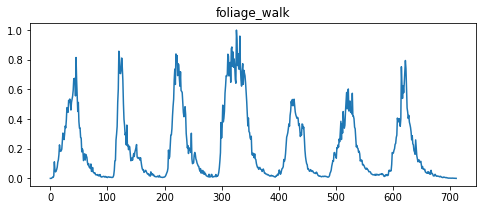

In [ ]:
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import wavfile
import matplotlib.pyplot as plt
import PIL.Image
import moviepy.editor

import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks

audio = {}

if not os.path.exists(wav_filename):
    audio_clip = moviepy.editor.AudioFileClip(wav_filename)
    audio_clip.write_audiofile(wav_filename, fps=44100, nbytes=2, codec='pcm_s16le')
track_name = os.path.basename(wav_filename)[:-4]
rate, signal = wavfile.read(wav_filename)
signal = np.mean(signal, axis=1) # to mono
signal = np.abs(signal)
# seed = signal.shape[0]
duration = signal.shape[0] / rate
frames = int(np.ceil(duration * fps))
samples_per_frame = signal.shape[0] / frames
audio[track_name] = np.zeros(frames, dtype=signal.dtype)
for frame in range(frames):
    start = int(round(frame * samples_per_frame))
    stop = int(round((frame + 1) * samples_per_frame))
    audio[track_name][frame] = np.mean(signal[start:stop], axis=0)
audio[track_name] /= max(audio[track_name])

for track in sorted(audio.keys()):
    plt.figure(figsize=(8, 3))
    plt.title(track)
    plt.plot(audio[track])
    plt.savefig(f'../{track}.png')

Run the next cell to define some functions we’ll need to use to generate our inference images.

In [ ]:
import random
def generate_zs_from_seeds(seeds,Gs):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

def convertZtoW(latent, truncation_psi=0.5, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def generate_images_in_w_space(dlatents, truncation_psi,folder='random'):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    if folder == 'random':
      temp_dir = 'frames%06d'%int(1000000*random.random())
    else:
      temp_dir = folder
    os.system('mkdir %s'%temp_dir)

    for row, dlatent in enumerate(dlatents):
        print('Generating image for step %d/%d ...' % (row, len(dlatents)))
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        PIL.Image.fromarray(row_images[0], 'RGB').save('%s/frame%05d.png' % (temp_dir, row))

## Generate Images

### Use Volume to interpolate between two seeds
The next cell will take two seed values and do a linear interpolation of them using the volume from your audio. When the audio is silent, it will be the first seed you list. When it is at its loudest it will be the second. Everything in between will be an interpolated value.

In [ ]:
network_pkl = '/content/drive/MyDrive/ai stuffs/forest_gothic-010414.pkl'
seeds=[1187,2955]
truncation_value = 0.7

#you probably won't need to edit anything below this
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

def get_ws(n, frames, seed):
    filename = f'../ws_{n}_{frames}_{seed}.npy'
    if not os.path.exists(filename):
        src_ws = np.random.RandomState(seed).randn(n, 512)
        ws = np.empty((frames, 512))
        for i in range(512):
            x = np.linspace(0, 3*frames, 3*len(src_ws), endpoint=False)
            y = np.tile(src_ws[:, i], 3)
            x_ = np.linspace(0, 3*frames, 3*frames, endpoint=False)
            y_ = interp1d(x, y, kind='quadratic', fill_value='extrapolate')(x_)
            ws[:, i] = y_[frames:2*frames]
        np.save(filename, ws)
    else:
        ws = np.load(filename)
    return ws

def lerp(v0, v1, t):
    return v0*(1.0-t)+v1*t


ends = generate_zs_from_seeds(seeds,Gs)
ends_w = []

for e in range(len(ends)):
  ends_w.append(convertZtoW(ends[e],0.5))

vectors = []
for f in range(frames):
  vectors.append(lerp(ends_w[0],ends_w[1],audio[track_name][f]))

generate_images_in_w_space(vectors,truncation_value)


Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating image for step 0/712 ...
Generating image for step 1/712 ...
Generating image for step 2/712 ...
Generating image for step 3/712 ...
Generating image for step 4/712 ...
Generating image for step 5/712 ...
Generating image for step 6/712 ...
Generating image for step 7/712 ...
Generating image for step 8/712 ...
Generating image for step 9/712 ...
Generating image for step 10/712 ...
Generating image for step 11/712 ...
Generating image for step 12/712 ...
Generating image for step 13/712 ...
Generating image for step 14/712 ...
Generating image for step 15/712 ...
Generating image for step 16/712 ...
Generating image for step 17/712 ...
Generating image for step 18/712 ...
Generating image for step 19/712 ...
Generating image for step 20/712 ...
Generating image for step 21/712 ...
Generating image for step 22/712

### Combine the frames into a video and add the audio track back to it

There’s probably a cleaner way to do this all in moviepy but I’m being lazy.

In [ ]:
!ffmpeg -r 60 -i /content/stylegan2/frames841649/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/sound-react-volume2.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
mp4_filename = '/content/foliage_walk_1187-2955.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/sound-react-volume2.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/drive/MyDrive/foliage_walk.wav')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')

[MoviePy] >>>> Building video /content/foliage_walk_1187-2955.mp4
[MoviePy] Writing audio in foliage_walk_1187-2955TEMP_MPY_wvf_snd.mp4


100%|██████████| 262/262 [00:00<00:00, 498.61it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/foliage_walk_1187-2955.mp4



100%|██████████| 713/713 [00:05<00:00, 134.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/foliage_walk_1187-2955.mp4 



### Use Volume to control truncation
In this example, we’ll use almost the same technique but use volume to change the truncation value. 

It’s helpful that both interpolation and truncation are essentially 0.0 to 1.0. This matches the volume signal’s output, but what if we wanted to alter it?

In [ ]:
seeds=[10]

seed_z = generate_zs_from_seeds(seeds,Gs)

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

rnd = np.random.RandomState(seeds[0])

temp_dir = '%s-trunc_frames%06d'%(track_name,int(1000000*random.random()))
os.system('mkdir %s'%temp_dir)

for f in range(frames):
  print('Rendering frame %d/%d ...' % (f,frames))
  Gs_kwargs.truncation_psi = audio[track_name][f]
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
  images = Gs.run(seed_z[0], None, **Gs_kwargs) # [minibatch, height, width, channel]
  PIL.Image.fromarray(images[0], 'RGB').save('%s/frame%05d.png' % (temp_dir,f))

In [ ]:
!ffmpeg -r 60 -i /content/stylegan2/AhCmonNowBaby-trunc_frames374288/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/sound-truncation-volume.mp4

In [ ]:
mp4_filename = '../volume-trunc-test-v2.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/sound-truncation-volume.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/stylegan2/AhCmonNowBaby.wav')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')

In [ ]:
seeds=[10]

seed_z = generate_zs_from_seeds(seeds,Gs)

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

rnd = np.random.RandomState(seeds[0])
temp_dir = '%s-trunc_frames%06d'%(track_name,int(1000000*random.random()))
os.system('mkdir %s'%temp_dir)

for f in range(frames):
  print('Rendering frame %d/%d ...' % (f,frames))

  #edit the next line to alter the volume signal
  # new_truncation_value = audio[track_name][f]*2 #multiply by 2 (0.0 to 2.0 for volume signal/truncation value now)
  new_truncation_value = (audio[track_name][f]-0.5)*2 #(-1.0 to 1.0 for volume signal/truncation value now)

  Gs_kwargs.truncation_psi = new_truncation_value
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
  images = Gs.run(seed_z[0], None, **Gs_kwargs) # [minibatch, height, width, channel]
  PIL.Image.fromarray(images[0], 'RGB').save('%s/frame%05d.png' % (temp_dir,f))

In [ ]:
!ffmpeg -r 60 -i /content/stylegan2/pleasureisallmine_01-stereo-trunc_frames623374/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/sound-truncation-volume.mp4

In [ ]:
mp4_filename = '../volume-trunc-test-v3.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/sound-truncation-volume.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/stylegan2/pleasureisallmine_01-stereo.wav')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')

## Using feature vectors

Let’s look at an example using a feature vector. In this case we’ll just use the straight audio signal.

Upload your feature vector to Colab and then reference it’s location with a variable.

In [ ]:
network_pkl = "/content/ffhq.pkl"
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

def generate_mov(seed, truncation, direction_vec, scale, n_frames, out_name = 'out', noise_spec = None, loop=True):
  """Generates a mov moving back and forth along the chosen direction vector"""
  # Example of reading a generated set of images, and storing as MP4.
  %mkdir out
  movieName = f'out/{out_name}.mp4'
  offset = -10
  step = 20 / n_frames
  imgs = []
  for i in range(n_frames):
    print(f'{i} / {n_frames}')
    
    
    batch_size = 1
    all_seeds = [seed] * batch_size
    all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
    all_w = Gs.components.mapping.run(all_z, None) # [minibatch, layer, component]
    if truncation != 1:
        w_avg = Gs.get_var('dlatent_avg')
        all_w = w_avg + (all_w - w_avg) * truncation # [minibatch, layer, component]
    all_w += direction_vec * offset * scale
    all_images = Gs.components.synthesis.run(all_w, **Gs_syn_kwargs)
    #save image and display
    final_im = PIL.Image.fromarray(np.median(all_images, axis=0).astype(np.uint8))
    imgs.append(final_im)
    #increase offset
    offset += step
  if loop:
    imgs += imgs[::-1]
  with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

In [ ]:
seed = 10 # starting seed (will appear at 0.5)
truncation = 0.7
feature = '/content/profile-c2.npy'
feature_range = 2 # feature_range maps the range of change in features 
scale = 1 # scale multiples the strength of the feature (1 is prob fine)

#-------------------

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
if truncation is not None:
  Gs_kwargs.truncation_psi = truncation
tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
w_avg = Gs.get_var('dlatent_avg')

# get starting z and w
rnd = np.random.RandomState(seed)
z = rnd.randn(1, *Gs.input_shape[1:])
w = Gs.components.mapping.run(z, None)

# make dir
feature_name=os.path.basename(feature)[:-4] 
dir = '%s_%s_range%02d_seed%05d'%(track_name,feature_name,feature_range,seed)
os.system('mkdir %s'%dir)

# setup
feature_vec = np.load(feature)
min_range = -feature_range
max_range = feature_range
offset = min_range #start value

#generate frames
for f in range(frames):
  print('Rendering frame %d/%d ...' % (f,frames))

  if truncation != 1:
    w = w_avg + (w - w_avg) * truncation # [minibatch, layer, component]
  
  w += feature_vec * offset * scale

  #save image and display
  image = Gs.components.synthesis.run(w, **Gs_syn_kwargs)
  PIL.Image.fromarray(image[0],'RGB').save('%s/frame%05d.png' % (dir,f))
  
  #increase offset
  offset = lerp( min_range,max_range,audio[track_name][f] )

  

In [ ]:
!ffmpeg -r 60 -i /content/stylegan2/pleasureisallmine_01-stereo_profile-c2_range02_seed00010/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/sound-feature-volume-range2.mp4

In [ ]:
mp4_filename = '../volume-feature-test-range2.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/sound-feature-volume-range2.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/stylegan2/pleasureisallmine_01-stereo.wav')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')

Let’s download the video.

In [ ]:
!ffmpeg -r 24 -i ./results/00004-generate-latent-walk/step%05d.png -vcodec libx264 -pix_fmt yuv420p noise-loop-2.mp4